In [1]:
import os
import sys
from dotenv import load_dotenv
import importlib

# 환경 변수 로드
load_dotenv()

# 프로젝트 루트 디렉토리를 Python 경로에 추가
project_root = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# 개발 중 수정사항 반영을 위한 모듈 리로드
modules_to_reload = ['graph.nodes.retrieval', 'graph.compile', 'rag.services.retriever']
for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

print("✅ 환경 설정 완료")


# 환경 변수 확인
def check_environment():
    """환경 변수 및 DB 연결 정보 확인"""
    print("\n=== DB 연결 정보 ===")
    print(f"POSTGRES_HOST: {os.getenv('POSTGRES_HOST')}")
    print(f"POSTGRES_PORT: {os.getenv('POSTGRES_PORT')}")
    print(f"POSTGRES_DB: {os.getenv('POSTGRES_DB')}")
    print(f"POSTGRES_USER: {os.getenv('POSTGRES_USER')}")
    print(f"OPENAI_API_KEY: {'✅ 설정됨' if os.getenv('OPENAI_API_KEY') else '❌ 미설정'}\n")

check_environment()


# Vectorstore 및 Workflow 초기화
from rag.services.retriever import create_vectorstore
from graph.compile import create_medical_rag_workflow

def initialize_vectorstore():
    """pgvector vectorstore 생성 및 연결 테스트"""
    try:
        vectorstore = create_vectorstore()
        print("✅ pgvector 연결 성공!")
        
        # 연결 테스트
        test_results = vectorstore.similarity_search("테스트", k=1)
        print(f"✅ 검색 테스트 성공 (결과 수: {len(test_results)}개)\n")
        return vectorstore
        
    except Exception as e:
        print(f"❌ pgvector 연결 실패: {e}")
        print("⚠️  vectorstore 없이 워크플로우를 생성합니다.\n")
        return None

vectorstore = initialize_vectorstore()
medical_app = create_medical_rag_workflow(vectorstore=vectorstore)
print("✅ Medical RAG 워크플로우 생성 완료!")

✅ 환경 설정 완료

=== DB 연결 정보 ===
POSTGRES_HOST: localhost
POSTGRES_PORT: 5432
POSTGRES_DB: sknproject4
POSTGRES_USER: root
OPENAI_API_KEY: ✅ 설정됨

SelfRAGState 클래스 정의 완료!
✅ pgvector 연결 성공!
✅ 검색 테스트 성공 (결과 수: 1개)

✅ Medical RAG 워크플로우 생성 완료!


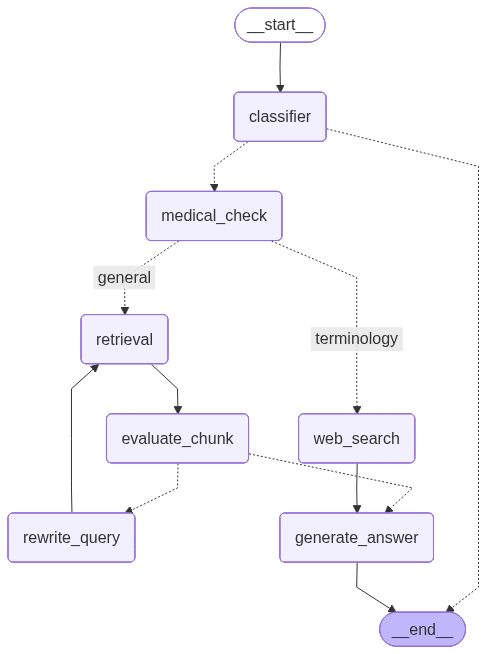

✅ 워크플로우 그래프 표시 완료


In [3]:
from IPython.display import Image, display

# 워크플로우 그래프 시각화
try:
    display(Image(medical_app.get_graph().draw_mermaid_png()))
    print("✅ 워크플로우 그래프 표시 완료")
except Exception as e:
    print(f"❌ 그래프 표시 오류: {e}")

In [2]:
def print_section_header(title):
    """섹션 헤더 출력"""
    print(f"\n{'='*60}")
    print(f" {title}")
    print(f"{'='*60}")

def print_test_result(question, result, test_number):
    """테스트 결과 출력"""
    print_section_header(f"테스트 {test_number}")
    print(f"질문: {question}\n")
    print(f"답변:\n{result.get('final_answer', '답변 없음')}\n")
    
    # 디버깅 정보
    print(f"{'─'*60}")
    print("📊 워크플로우 디버깅 정보:")
    print(f"  • 의학 질문 여부: {'✅ 예' if not result.get('need_quit', False) else '❌ 아니오'}")
    print(f"  • 용어 질문 여부: {'✅ 예' if result.get('is_terminology', False) else '❌ 아니오'}")
    print(f"  • 검색 문서 수: {len(result.get('retrieved_docs', []))}개")
    print(f"  • 문서 관련성: {'✅ 관련있음' if result.get('is_relevant', False) else '❌ 관련없음'}")
    print(f"  • 쿼리 재작성 횟수: {result.get('rewrite_count', 0)}회")

def run_workflow_tests(test_questions):
    """워크플로우 테스트 실행"""
    print_section_header("워크플로우 테스트 시작")
    
    for i, question in enumerate(test_questions, 1):
        try:
            result = medical_app.invoke({"question": question})
            print_test_result(question, result, i)
        except Exception as e:
            print(f"\n❌ 테스트 {i} 실행 오류: {e}")
    
    print_section_header("테스트 완료!")


# 테스트 질문 정의
test_questions = [
    "대장암 치료 방법은 무엇인가요?",
    "항암화학요법의 부작용은?",
]

# 테스트 실행
run_workflow_tests(test_questions)


 워크플로우 테스트 시작

 테스트 1
질문: 대장암 치료 방법은 무엇인가요?

답변:
1. 핵심 답변
- 대장암의 치료는 병기에 따라 달라지며, 기본 원칙은 근치적 절제수술입니다. 수술 후 병리학적 진단으로 최종 병기를 확정하고 필요하면 보조 항암화학요법을 시행합니다. 또한 조기 진단이나 특정 경우에는 내시경적 점막절제술이나 점막하 박리술도 이용될 수 있습니다. [문서 1][문서 2][문서 3]

2. 상세 설명
- 진단과 병기 결정
  - 대장암의 진단은 대장내시경검사와 조직 생검으로 확정되고, 진단 후에는 병력, 가족력, 신체검사, 혈액검사, 영상검사를 통해 병기를 결정하고 치료 방침을 정합니다. [문서 5]
- 치료 기본 원칙
  - 치료의 기본 원칙은 근치적 절제수술이며, 병기가 확정되면 수술 후 병리학적 진단으로 최종 병기를 결정하고 필요 시 보조 항암화학요법 등 추가 치료를 시행합니다. [문서 1]
- 수술 접근 방식
  - 전통적인 근치적 절제수술이 핵심이지만, 최근에는 조기에 한정된 병변에 대해 내시경적 점막절제술(MEM)이나 점막하 박리술(ESD)과 같은 비수술적 접근도 시행될 수 있습니다. [문서 2][문서 3]
- 치료 성적 향상 요인
  - 대장암 치료 성적은 발병 기전에 대한 이해, 조기 진단, 영상 및 병리학적 진단의 발전, 수술 기술의 정교화, 방사선 및 항암화학요법의 발전 등 다양한 요인에 의해 향상되었습니다. 특히 직장암의 생존율과 치료 성적이 크게 향상되었다고 기술되어 있습니다. [문서 4]

3. 주의사항
- 이 내용은 일반 원칙을 정리한 것이며, 구체적인 치료 방법은 개인의 병기, 건강 상태, 수술 가능성 등에 따라 달라질 수 있습니다. 반드시 주치의와 상의하여 개인 맞춤 치료 계획을 세우시기 바랍니다. [문서 1][문서 5]

참고 문서
- [문서 1] (대장암의 치료 원칙: 근치적 절제수술이 기본, 수술 후 병리로 최종 병기 결정 및 보조 치료) - https://www.google.com/search?q=%EB%AC